# Определение стоимости автомобилей
## Описание проекта
Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.

## Инструкция по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Простые модели иногда работают лучше.
1. Загрузите и подготовьте данные.
2. Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
3. Проанализируйте скорость работы и качество моделей.

__Примечания__:
* Для оценки качества моделей применяйте метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
* Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

## Описание данных
**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## 1. Загрузите и подготовьте данные.

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time 
import warnings

from catboost import CatBoostRegressor
import lightgbm as ltb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

try:
    data = pd.read_csv('autos.csv')
    display(data.info())
    display(data.describe())
    display(data[:5])
except:
    data = pd.read_csv('/datasets/autos.csv')
    display(data.info())
    display(data.describe())
    display(data[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
warnings.filterwarnings('ignore')

**Отметим сразу, что в следующих переменных мы видим неадекватные показатели:**
* Price: 0 евро
* RegistrationYear: мин год 1000, и макс год 9999
* Power: от 0 л.с. до 20000 л.с.
* RegistrationMonth: 0-ой месяц
Следовательно нужно посмотреть и отфильтровать данные от аномалий

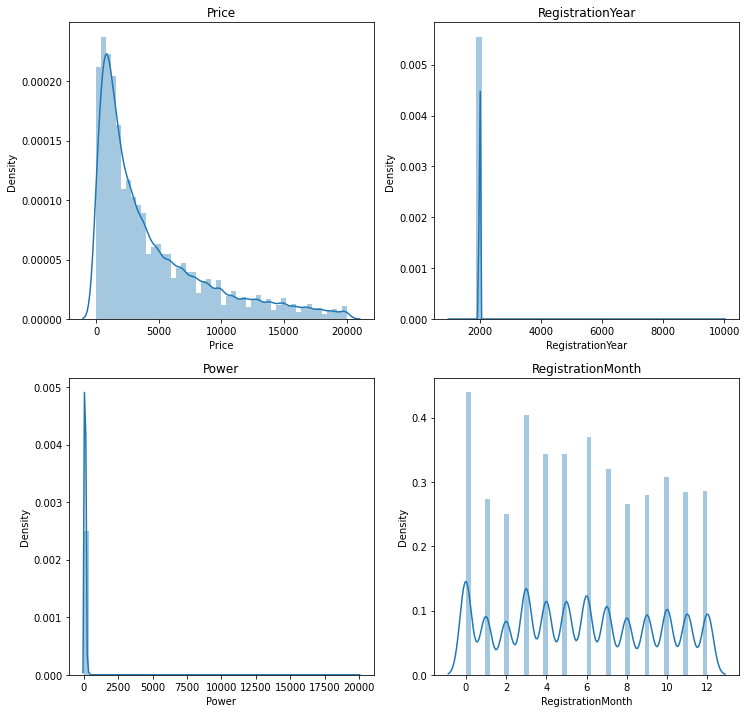

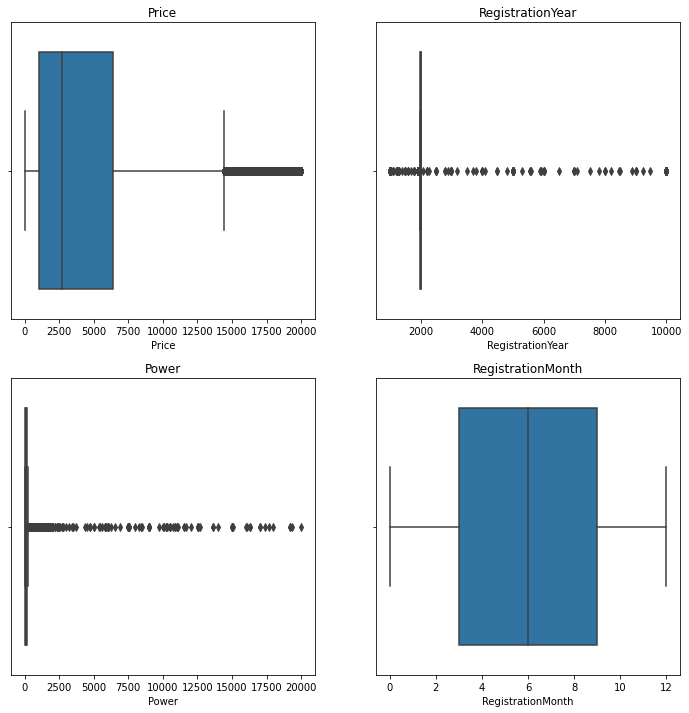

In [4]:
anomal = ['Price','RegistrationYear','Power','RegistrationMonth']
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for column, ax in zip(anomal, axes.ravel()):
    ax.set_title(column)
    sns.distplot(data[column], ax=ax)
    
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for column, ax in zip(anomal, axes.ravel()):
    ax.set_title(column)
    sns.boxplot(data[column], ax=ax)

Итак, мы видим, что с данными явно что-то не так. Поэтому была предпринята следующая фильтрация:
* Price > 1000, хотя и за 2000 вывглядит как выброс, но все же оставим;
* 1990 <= RegistrationYear <= 2022, думаю будет разумно не заглядывать в будущее и слишком уходить в прошлое. 
* 50 < Power < 1000, хотя даже так в среднем мы вряд ли найдем машинку с 50 лошадями и монстра с табуном из примерно 1000 лошадей. 
* RegistrationMonth > 0, нулевого месяца не знаем

In [5]:
#Уберем явно неверные значения мин и макс по столбцам:
data =  data.query('Price > 1000 and RegistrationYear <=2022 and RegistrationYear >= 1990 and Power > 50 and Power < 1000 and RegistrationMonth > 0 ')
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,226308.000000,226308.000000,226308.000000,226308.000000,226308.000000,226308.0,226308.000000
mean,5978.139792,2004.947991,130.200992,125509.239620,6.429967,0.0,51825.492568
std,4593.579944,5.363651,54.107050,37876.260578,3.349169,0.0,25676.048222
min,1001.000000,1990.000000,51.000000,5000.000000,1.000000,0.0,1067.000000
25%,2350.000000,2001.000000,90.000000,100000.000000,4.000000,0.0,31535.000000
50%,4499.000000,2005.000000,120.000000,150000.000000,6.000000,0.0,51067.000000
75%,8400.000000,2008.000000,156.000000,150000.000000,9.000000,0.0,72506.250000
max,20000.000000,2019.000000,999.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
data.query('DateCreated >= "2016-04-30 00:00:00"')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


In [7]:
data.query('RegistrationYear > 2016')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354007,2016-04-04 21:40:20,10980,NaN,2018,manual,75,NaN,20000,1,NaN,volkswagen,no,2016-04-04 00:00:00,0,44801,2016-04-07 00:15:36
354099,2016-03-17 15:45:46,4900,NaN,2017,manual,69,polo,150000,12,gasoline,volkswagen,NaN,2016-03-17 00:00:00,0,32791,2016-03-25 17:51:29
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04


**Выделим и заранее удалим признаки, никак не влияющие на прогноз цены**\
**Также можем заметить, что половина признаков имеет null-значения, которые следует обработать**

In [8]:
data = data.drop(['DateCrawled', 'DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1)
data = data.fillna('None')        

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226308 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              226308 non-null  int64 
 1   VehicleType        226308 non-null  object
 2   RegistrationYear   226308 non-null  int64 
 3   Gearbox            226308 non-null  object
 4   Power              226308 non-null  int64 
 5   Model              226308 non-null  object
 6   Kilometer          226308 non-null  int64 
 7   RegistrationMonth  226308 non-null  int64 
 8   FuelType           226308 non-null  object
 9   Brand              226308 non-null  object
 10  NotRepaired        226308 non-null  object
dtypes: int64(5), object(6)
memory usage: 20.7+ MB


**Проведем поиск и удаление дубликатов**

In [9]:
data[data.duplicated(keep=False)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
14,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no
20,10400,coupe,2009,manual,160,scirocco,100000,4,petrol,volkswagen,no
27,6900,sedan,2008,manual,99,civic,60000,11,petrol,honda,no
47,2100,wagon,1998,auto,193,5er,150000,2,petrol,bmw,no
64,14999,convertible,2007,manual,218,3er,50000,8,petrol,bmw,no
...,...,...,...,...,...,...,...,...,...,...,...
354320,1500,sedan,1999,manual,75,golf,150000,4,petrol,volkswagen,None
354325,12800,convertible,1991,manual,211,other,150000,7,petrol,porsche,no
354333,13850,wagon,2012,manual,156,accord,125000,10,petrol,honda,no
354352,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no


In [10]:
data = data.drop_duplicates().reset_index(drop=True)

**Мы видим, что у нас есть ряд категориальных признаков, которые нужно перевести в числа, и сделаем через OHE.**

In [11]:
data_ohe = pd.get_dummies(data, drop_first=True)

**Разделим данные на выборки через train_test_split**

In [12]:
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.5, random_state=12345)
features_valid, features_test, target_valid,target_test = train_test_split(features_valid_test, target_valid_test, test_size = 0.5, random_state=12345)


**Количественные признаки довольно разные по масштабам. Следует их привести к одному масштабу**

In [13]:
numeric = ['Power', 'Kilometer', 'RegistrationYear', 'RegistrationMonth']

scaler = StandardScaler()
scaler.fit(features_train.loc[:,numeric])
features_train.loc[:,numeric] = scaler.transform(features_train.loc[:,numeric])
features_valid.loc[:,numeric] = scaler.transform(features_valid.loc[:,numeric])
features_test.loc[:,numeric] = scaler.transform(features_test.loc[:,numeric])

## 2. Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
1. Попробовать различные модели
2. Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
3. Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

In [14]:
def model_eval(model, features_train, target_train, features_test, target_test):
    #скорость обучения
    start = time.time()    
    model.fit(features_train, target_train)
    training_time = time.time() - start
    #скорость предсказывания
    start = time.time()  
    target_pred = model.predict(features_test)
    predict_time = time.time() - start

    return print('Скорость обучения:', training_time, 'Скорость предсазания:',predict_time)

**DecisionTree**

In [15]:
%%time

dt_table = defaultdict(list)

dt_best_model = None
dt_best_rmse = 100000
dt_max_depth = 0

for depth in range(1,7):
    dt_model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    dt_model.fit(features_train, target_train)
    dt_predictions = dt_model.predict(features_valid)
    dt_rmse = mean_squared_error(target_valid, dt_predictions, squared=False)
    if dt_rmse < dt_best_rmse:
        dt_best_model = dt_model
        dt_best_rmse = dt_rmse
        dt_max_depth = depth
    dt_table['RMSE'].append(dt_best_rmse)
    dt_table['depth'].append(depth)
print('-------------------------------------------------')
print("Лучший RMSE:", dt_best_rmse)
print('Глубина деревьев: ', dt_max_depth)
print(model_eval(dt_model, features_train, target_train, features_valid, target_valid))

pd.DataFrame(dt_table).sort_values(by='RMSE')

-------------------------------------------------
Лучший RMSE: 2361.6683113677914
Глубина деревьев:  6
Скорость обучения: 1.7581532001495361 Скорость предсазания: 0.09376931190490723
None
Wall time: 8.88 s


,RMSE,depth
5,2361.668311,6
4,2544.525915,5
3,2760.485069,4
2,3068.850688,3
1,3349.005501,2
0,3824.599805,1


**RandomForest**

In [16]:
%%time
from collections import defaultdict

rf_table = defaultdict(list)

rf_best_model = None
rf_best_rmse = 100000
rf_max_depth = 0

for depth in range(2,8):
    rf_model = RandomForestRegressor(random_state=12345, n_estimators=20, max_depth=depth)
    rf_model.fit(features_train, target_train)
    rf_predictions = rf_model.predict(features_valid)
    rf_rmse = mean_squared_error(target_valid, rf_predictions, squared=False)
    if rf_rmse < rf_best_rmse:
        rf_best_model = rf_model
        rf_best_rmse = rf_rmse
        rf_max_depth = depth
    rf_table['RMSE'].append(rf_rmse)
    rf_table['depth'].append(depth)
print('-------------------------------------------------')
print("Лучший RMSE:", rf_best_rmse)
print('Глубина деревьев: ', rf_max_depth)
print(model_eval(dt_model, features_train, target_train, features_valid, target_valid))

pd.DataFrame(rf_table).sort_values(by='RMSE')

-------------------------------------------------
Лучший RMSE: 2163.902689408754
Глубина деревьев:  7
Скорость обучения: 1.8066942691802979 Скорость предсазания: 0.12615513801574707
None
Wall time: 1min 37s


,RMSE,depth
5,2163.902689,7
4,2299.072036,6
3,2493.304837,5
2,2713.125970,4
1,3038.071461,3
0,3347.040893,2


**CatBoost**

In [17]:
%%time 

cat_model = CatBoostRegressor(learning_rate = 0.4, loss_function="RMSE", iterations=50, random_state=12345)
cat_model.fit(features_train, target_train, verbose=10)


cat_predictions = cat_model.predict(features_valid)
cat_rmse = mean_squared_error(target_valid, cat_predictions,squared=False)

print("RMSE:", cat_rmse)
print(model_eval(dt_model, features_train, target_train, features_valid, target_valid))

0:	learn: 3559.4559735	total: 170ms	remaining: 8.32s
10:	learn: 1974.1026796	total: 349ms	remaining: 1.24s
20:	learn: 1851.2735989	total: 512ms	remaining: 707ms
30:	learn: 1794.5189293	total: 663ms	remaining: 406ms
40:	learn: 1758.2533859	total: 817ms	remaining: 179ms
49:	learn: 1730.8414123	total: 958ms	remaining: 0us
RMSE: 1742.2809230363716
Скорость обучения: 1.7369256019592285 Скорость предсазания: 0.10936617851257324
None
Wall time: 3.49 s


Text(0.5, 1.0, 'cat_importances')

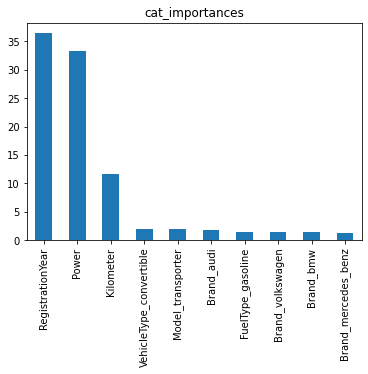

In [18]:
cat_importances = pd.Series(cat_model.get_feature_importance(), index=features_train.columns).sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('cat_importances')

**LightGBM**

In [19]:
%%time

lgbm_model = LGBMRegressor(learning_rate = 0.4, n_estimators = 10, num_iterations = 70, random_state=12345 )
lgbm_model.fit(features_train, target_train)
lgbm_predictions = lgbm_model.predict(features_valid)
lgbm_rmse = mean_squared_error(target_valid, lgbm_predictions,squared=False)

print("RMSE:", lgbm_rmse)
print(model_eval(dt_model, features_train, target_train, features_valid, target_valid))

RMSE: 1659.4338155615428
Скорость обучения: 1.7768425941467285 Скорость предсазания: 0.09376382827758789
None
Wall time: 3.31 s


Text(0.5, 1.0, 'lgbm_importances')

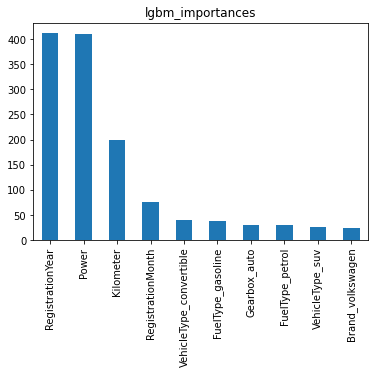

In [20]:
lgbm_importances = pd.Series(lgbm_model.feature_importances_,index=features_train.columns).sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('lgbm_importances')
# plt.tight_layout()
# plt.savefig('lgbm_importances-01.png')
# plt.show()

**Вывод:** Заметим, что наиболее важными признаками моделями CatBoost и LightGBM были выделены: мощность, время регистрации авто и пробег, - что вполне соответсвует действительности при определении цены авто на вторичном рынке  

## 3. Проанализируйте скорость работы и качество моделей.

Наилучшая модель в данном исследовании была получена через LightGBM.\
Несмотря на то, что CatBoost проявил несколько бОльшую скорость, LightGBM показал наилучшее качество предсказаний.\
Поэтому именно ее проверим на тестовой выборке

In [21]:
%%time

features_train_valid = pd.concat([features_train, features_valid], axis=0, ignore_index=False)
target_train_valid = pd.concat([target_train, target_valid], axis=0, ignore_index=False)

lgbm_model.fit(features_train_valid, target_train_valid)
lgbm_predictions_test = lgbm_model.predict(features_test)
lgbm_rmse_test = mean_squared_error(target_test, lgbm_predictions_test,squared=False)

print("RMSE:", lgbm_rmse_test)
print(model_eval(dt_model, features_train, target_train, features_test, target_test))

RMSE: 1675.2096647225246
Скорость обучения: 1.791381597518921 Скорость предсазания: 0.10934805870056152
None
Wall time: 3.91 s
